## Import & chargement des données

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Options d'affichage
pd.set_option("display.max_columns", None)
plt.style.use("default")

# Chargement du dataset
df = pd.read_excel("E_i.xlsx", parse_dates=["Date"])

print(df.shape)
df.head()


(1048575, 13)


,ID,Date,Prelibt,CIP,DOSE,dosage,Freq,Durée,DCI,ATC,is_ARV,classe_th,E_I
0,1,2004-04-14,BACTRIM cp Ad,3001069,1 Comprimé,400 mg; 80 mg,1 fois / jour,30 jour(s),SULFAMETHOXAZOLE; TRIMETHOPRIME,NAN,0,NaN,NaN
1,1,2004-04-14,KALETRA caps,3566794,3 Capsule,200 mg; 50 mg,Toutes les 12 heures,30 jour(s),LOPINAVIR; RITONAVIR,J05AR10,1,2 IP,NaN
2,1,2004-04-14,COMBIVIR cp enrobé,3466271,1 Comprimé,150 mg; 300 mg,Toutes les 12 heures,30 jour(s),LAMIVUDINE; ZIDOVUDINE,J05AR01,1,2 INTI,NaN
3,2,2013-10-01,TRUVADA 200MG/245MG CPR 30,3656563,1 comprimé,200 mg; 300 mg,par jour,1 mois,EMTRICITABINE; MALEATE DE TENOFOVIR DISOPROXIL,J05AR03,1,2 INTI,NaN
4,2,2013-10-01,ISENTRESS 400MG CPR 60,3830848,2 comprimés,"434,4 mg",par jour,1 mois,RALTEGRAVIR,J05AJ01,1,INI,NaN


In [3]:
import pandas as pd
import numpy as np

def normalize_missing_values(df):
    # Étape 1 : remplacer None par NaN
    df = df.where(pd.notnull(df), np.nan)

    # Étape 2 : nettoyer les strings
    df = df.replace(
        [
            "", " ", "   ",
            "NaN", "nan", "NAN",
            "None", "none",
            "NULL", "null",
            "-", "?"
        ],
        np.nan
    )

    # Étape 3 : strip des colonnes texte
    for col in df.select_dtypes(include="object"):
        df[col] = df[col].str.strip()

    return df
df = normalize_missing_values(df)


In [7]:
missing_pct = 100-(df.isna().mean() * 100).round(2)
missing_pct.sort_values(ascending=False)

ID           100.00
Date         100.00
Prelibt      100.00
CIP          100.00
is_ARV       100.00
Durée         97.64
Freq          97.42
DCI           95.80
DOSE          95.52
dosage        93.49
ATC           70.49
classe_th     38.16
E_I           13.05
dtype: float64

## Création des entités clés

### 1.1 Visite médicale = (ID, Date)

In [4]:
df["visite_id"] = df["ID"].astype(str) + "_" + df["Date"].astype(str)


### 1.2 Vérification rapide

In [5]:
df[["ID", "Date", "visite_id"]].head()


,ID,Date,visite_id
0,1,2004-04-14,1_2004-04-14
1,1,2004-04-14,1_2004-04-14
2,1,2004-04-14,1_2004-04-14
3,2,2013-10-01,2_2013-10-01
4,2,2013-10-01,2_2013-10-01


## Analyses descriptives globales

### 2.1 Volumes globaux

In [9]:
nb_patients = df["ID"].nunique()
nb_visites = df["visite_id"].nunique()
nb_prescriptions = len(df)
nb_medicaments = df["CIP"].nunique()

summary = pd.DataFrame({
    "Indicateur": ["Patients", "Visites", "Prescriptions", "Médicaments distincts"],
    "Valeur": [nb_patients, nb_visites, nb_prescriptions, nb_medicaments]
})

summary


,Indicateur,Valeur
0,Patients,12859
1,Visites,237967
2,Prescriptions,1048575
3,Médicaments distincts,11595


## Nombre de prescriptions uniques par patient

### par CIP

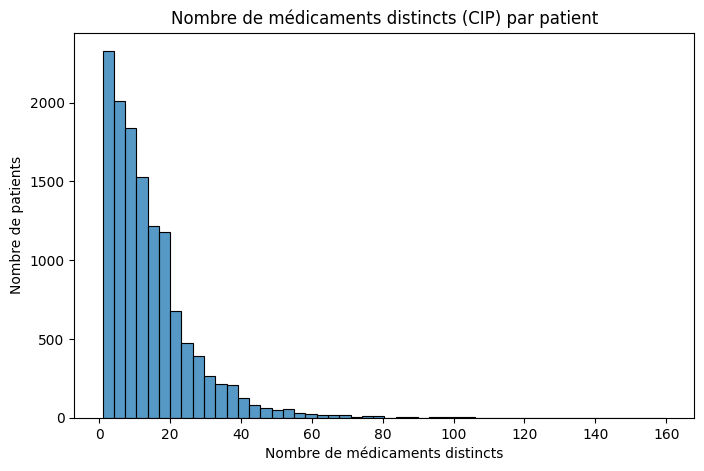

In [14]:
presc_unique_per_patient = (
    df.groupby("ID")["CIP"]
      .nunique()
)

plt.figure(figsize=(8,5))
sns.histplot(presc_unique_per_patient, bins=50)
plt.title("Nombre de médicaments distincts (CIP) par patient")
plt.xlabel("Nombre de médicaments distincts")
plt.ylabel("Nombre de patients")
plt.show()
 

In [19]:
presc_unique_per_patient.describe()   

count    12859.000000
mean        14.146123
std         12.150769
min          1.000000
25%          6.000000
50%         11.000000
75%         19.000000
max        160.000000
Name: CIP, dtype: float64

## Poly-prescription (médicaments par visite)

In [19]:
meds_per_visite = df.groupby("visite_id").size()

meds_per_visite.describe()


count    237967.000000
mean          4.406388
std           3.235265
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          38.000000
dtype: float64

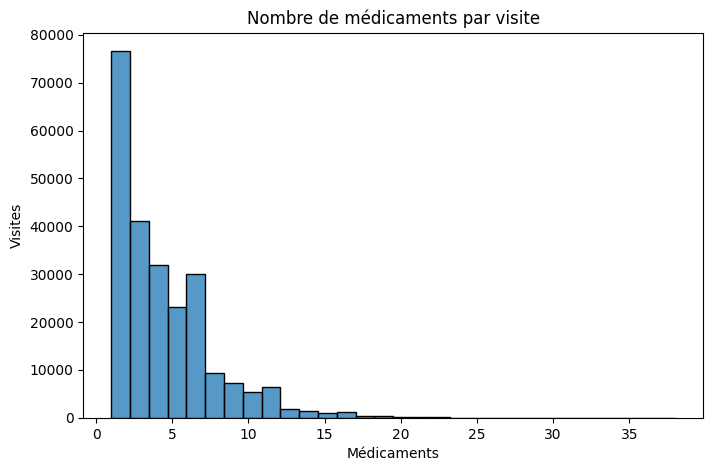

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(meds_per_visite, bins=30)
plt.title("Nombre de médicaments par visite")
plt.xlabel("Médicaments")
plt.ylabel("Visites")
plt.show()


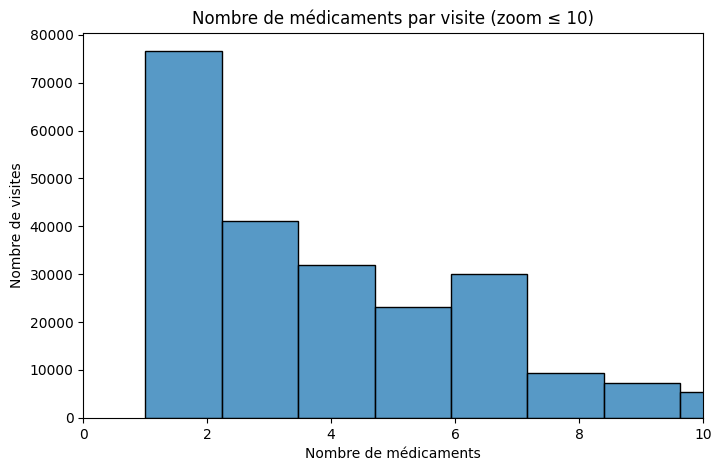

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(meds_per_visite, bins=30)
plt.xlim(0, 10)
plt.title("Nombre de médicaments par visite (zoom ≤ 10)")
plt.xlabel("Nombre de médicaments")
plt.ylabel("Nombre de visites")
plt.show()


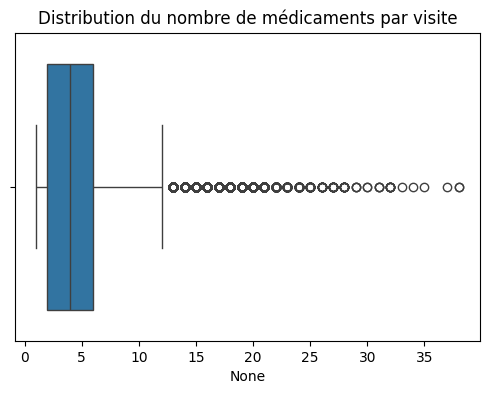

In [21]:
plt.figure(figsize=(6,4))
sns.boxplot(x=meds_per_visite)
plt.title("Distribution du nombre de médicaments par visite")
plt.show()


## Évolution du nombre de prescriptions au fil des visites

In [20]:
df = df.sort_values(["ID", "Date"])


In [21]:
df["visit_order"] = (
    df.groupby("ID")["Date"]
      .rank(method="dense")
      .astype(int)
)


In [22]:
meds_per_visit = (
    df.groupby(["ID", "visit_order"])["CIP"]
      .nunique()
      .reset_index(name="nb_medicaments")
)


In [23]:
meds_per_visit

,ID,visit_order,nb_medicaments
0,1,1,3
1,2,1,5
2,2,2,3
3,2,3,4
4,2,4,2
...,...,...,...
237962,900000,8,1
237963,900000,9,1
237964,900000,10,1
237965,1000000,1,2


In [24]:
evolution = (
    meds_per_visit
    .groupby("visit_order")["nb_medicaments"]
    .mean()
)


visit_order
1       3.613345
2       3.772251
3       3.861435
4       3.943306
5       3.972894
         ...    
267     7.000000
268    19.000000
269     7.000000
270     7.000000
271    19.000000
Name: nb_medicaments, Length: 271, dtype: float64

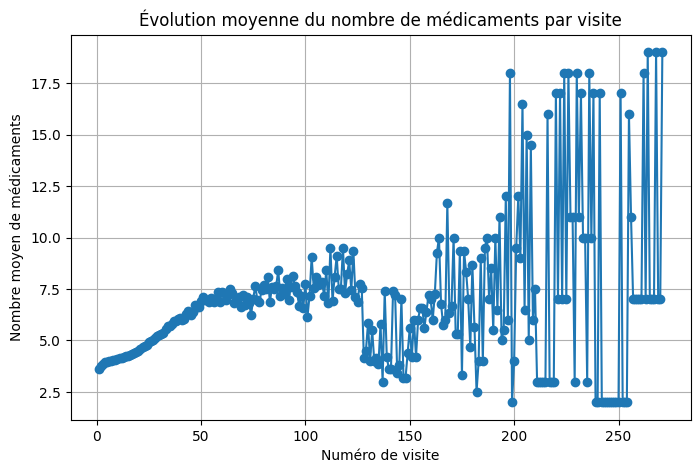

In [25]:
plt.figure(figsize=(8,5))
plt.plot(evolution.index, evolution.values, marker="o")
plt.title("Évolution moyenne du nombre de médicaments par visite")
plt.xlabel("Numéro de visite")
plt.ylabel("Nombre moyen de médicaments")
plt.grid(True)
plt.show()


In [30]:
patients_per_visit = (
    meds_per_visit
    .groupby("visit_order")["ID"]
    .nunique()
)



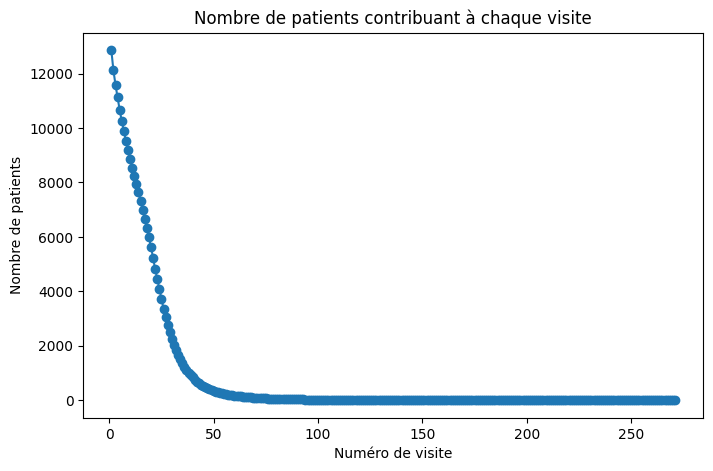

In [31]:
plt.figure(figsize=(8,5))
plt.plot(patients_per_visit.index, patients_per_visit.values, marker="o")
plt.title("Nombre de patients contribuant à chaque visite")
plt.xlabel("Numéro de visite")
plt.ylabel("Nombre de patients")
plt.show()


In [32]:
max_visits = 50
filtered = meds_per_visit[meds_per_visit["visit_order"] <= max_visits]


In [36]:
evolution = (
    filtered
    .groupby("visit_order")["nb_medicaments"]
    .mean()
)


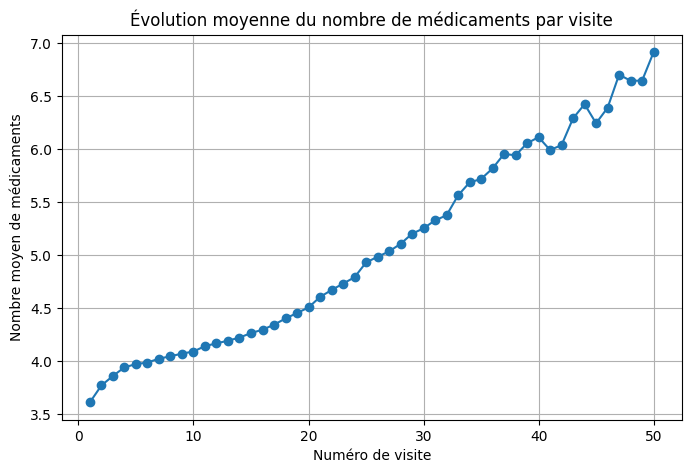

In [37]:
plt.figure(figsize=(8,5))
plt.plot(evolution.index, evolution.values, marker="o")
plt.title("Évolution moyenne du nombre de médicaments par visite")
plt.xlabel("Numéro de visite")
plt.ylabel("Nombre moyen de médicaments")
plt.grid(True)
plt.show()


In [38]:
pct_change = (evolution.iloc[-1] / evolution.iloc[0] - 1) * 100
pct_change


91.41341367566149

In [27]:
arv_nonarv_per_visit = (
    df.groupby(["ID", "visit_order", "is_ARV"])["CIP"]
      .nunique()
      .unstack(fill_value=0)
      .reset_index()
)

arv_nonarv_per_visit.head()


is_ARV,ID,visit_order,0,1
0,1,1,1,2
1,2,1,3,2
2,2,2,1,2
3,2,3,1,3
4,2,4,0,2


## Nombre de visite patien dans le temps 

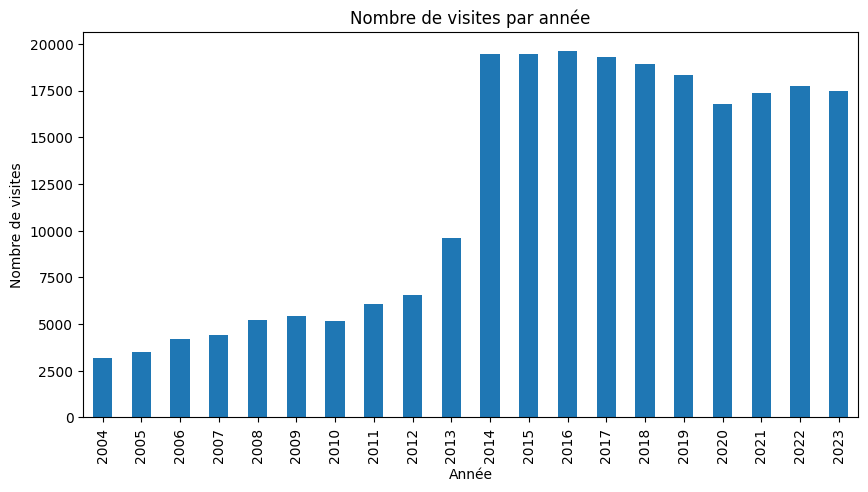

In [39]:
visites_par_an = df.groupby(df["Date"].dt.year)["visite_id"].nunique()
visites_par_an.plot(kind="bar", figsize=(10,5))
plt.title("Nombre de visites par année")
plt.xlabel("Année")
plt.ylabel("Nombre de visites")
plt.show()


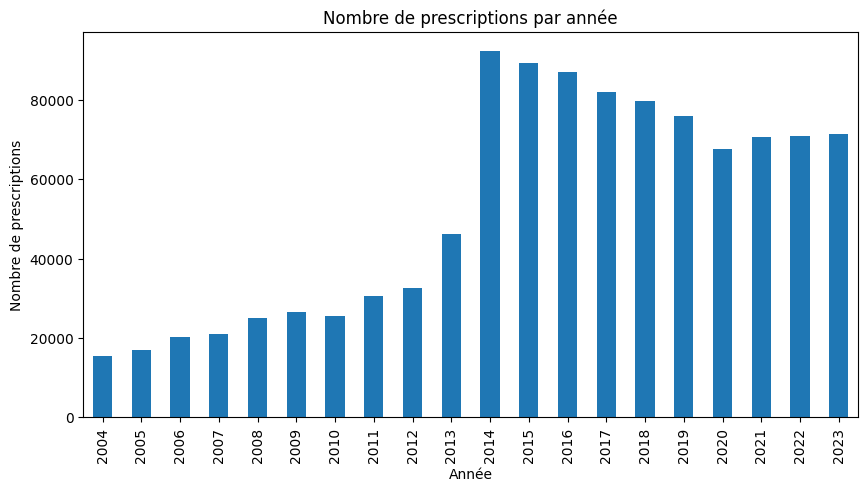

In [40]:
presc_par_an = df.groupby(df["Date"].dt.year).size()
presc_par_an.plot(kind="bar", figsize=(10,5))
plt.title("Nombre de prescriptions par année")
plt.xlabel("Année")
plt.ylabel("Nombre de prescriptions")
plt.show()


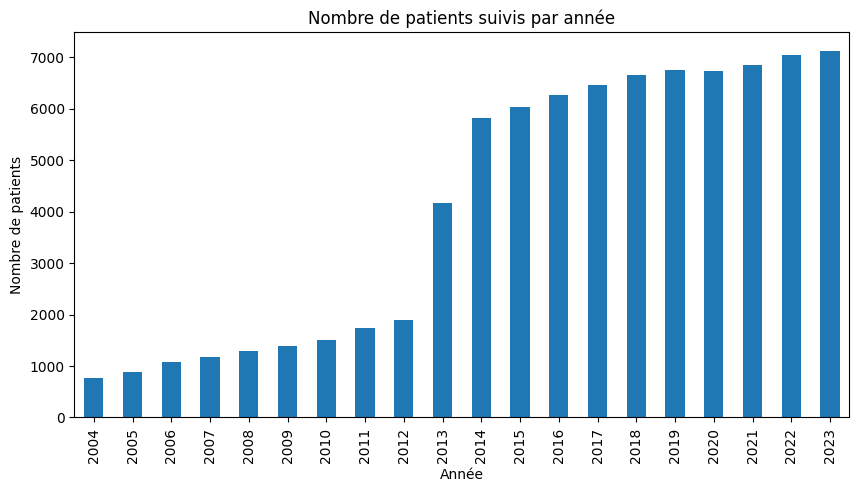

In [41]:
patients_par_an = df.groupby(df["Date"].dt.year)["ID"].nunique()
patients_par_an.plot(kind="bar", figsize=(10,5))
plt.title("Nombre de patients suivis par année")
plt.xlabel("Année")
plt.ylabel("Nombre de patients")
plt.show()


## visite / patien 

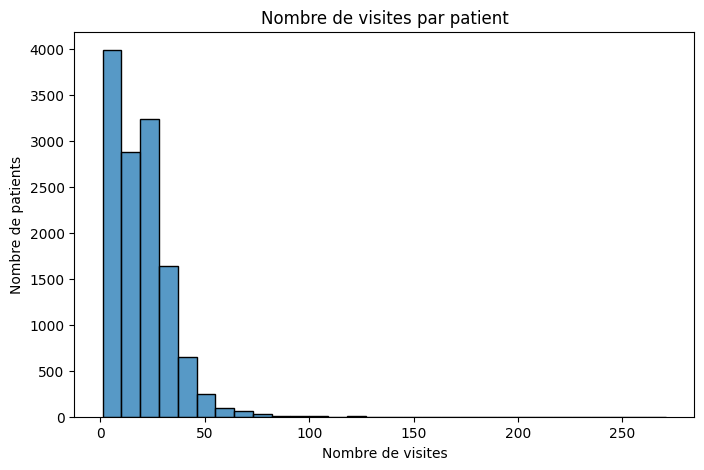

In [42]:
visites_par_patient = df.groupby("ID")["visite_id"].nunique()
plt.figure(figsize=(8,5))
sns.histplot(visites_par_patient, bins=30)
plt.title("Nombre de visites par patient")
plt.xlabel("Nombre de visites")
plt.ylabel("Nombre de patients")
plt.show()


## Médicaments les plus prescrits

### 4.1 Top médicaments (nom commercial)

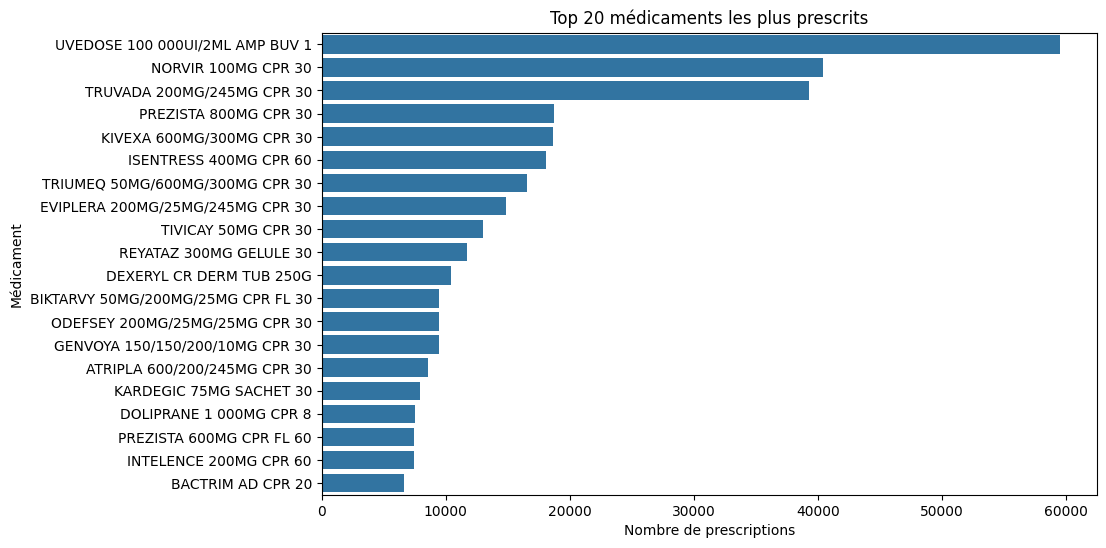

In [25]:
top_meds = df["Prelibt"].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_meds.values, y=top_meds.index)
plt.title("Top 20 médicaments les plus prescrits")
plt.xlabel("Nombre de prescriptions")
plt.ylabel("Médicament")
plt.show()


### 4.2 Top DCI

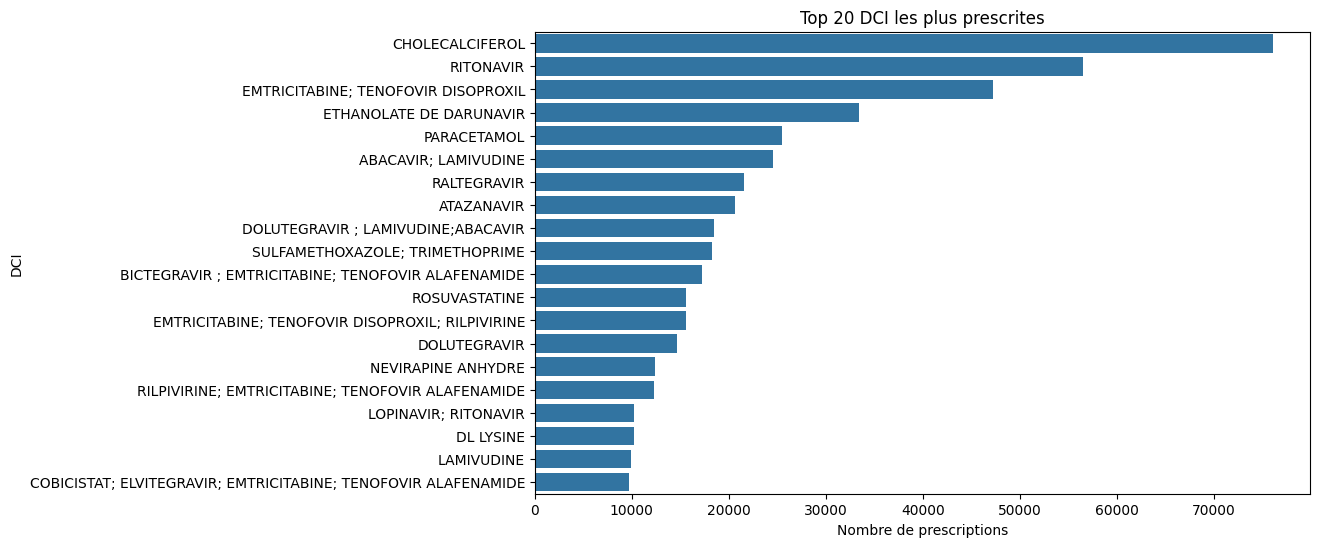

In [26]:
top_dci = df["DCI"].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_dci.values, y=top_dci.index)
plt.title("Top 20 DCI les plus prescrites")
plt.xlabel("Nombre de prescriptions")
plt.ylabel("DCI")
plt.show()


## ARV vs non-ARV

### 5.1 Proportions

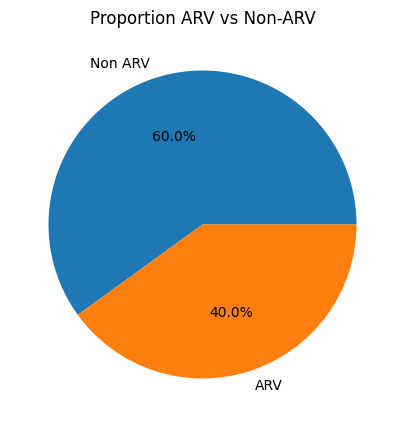

In [27]:
arv_counts = df["is_ARV"].value_counts().rename({0: "Non ARV", 1: "ARV"})

plt.figure(figsize=(5,5))
arv_counts.plot(kind="pie", autopct="%1.1f%%")
plt.title("Proportion ARV vs Non-ARV")
plt.ylabel("")
plt.show()


## Analyses spécifiques ARV

### 6.1 Répartition des classes thérapeutiques

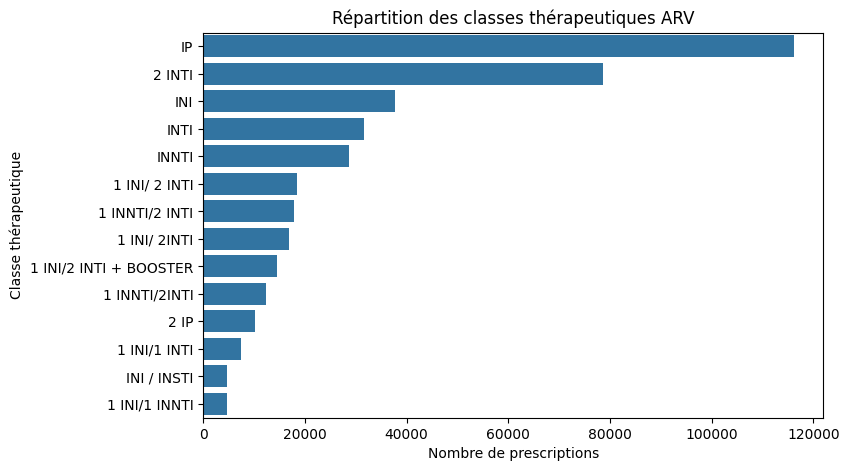

In [29]:
arv_df = df[df["is_ARV"] == 1]

classe_counts = arv_df["classe_th"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=classe_counts.values, y=classe_counts.index)
plt.title("Répartition des classes thérapeutiques ARV")
plt.xlabel("Nombre de prescriptions")
plt.ylabel("Classe thérapeutique")
plt.show()


### 6.2 Nombre d’ARV par visite

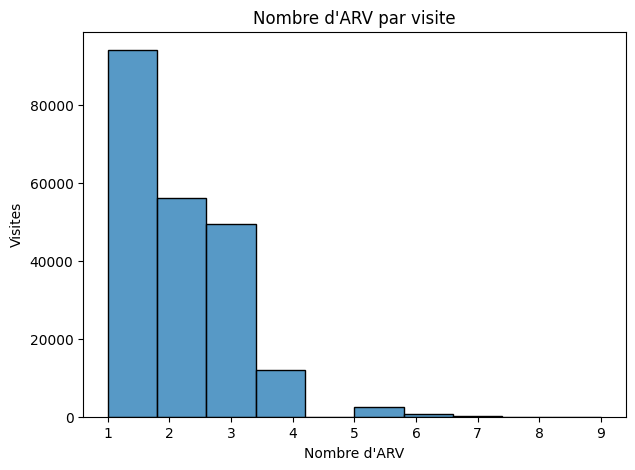

In [30]:
arv_per_visite = arv_df.groupby("visite_id").size()

plt.figure(figsize=(7,5))
sns.histplot(arv_per_visite, bins=10)
plt.title("Nombre d'ARV par visite")
plt.xlabel("Nombre d'ARV")
plt.ylabel("Visites")
plt.show()


### 6.3 Co-prescription des classes ARV (heatmap)

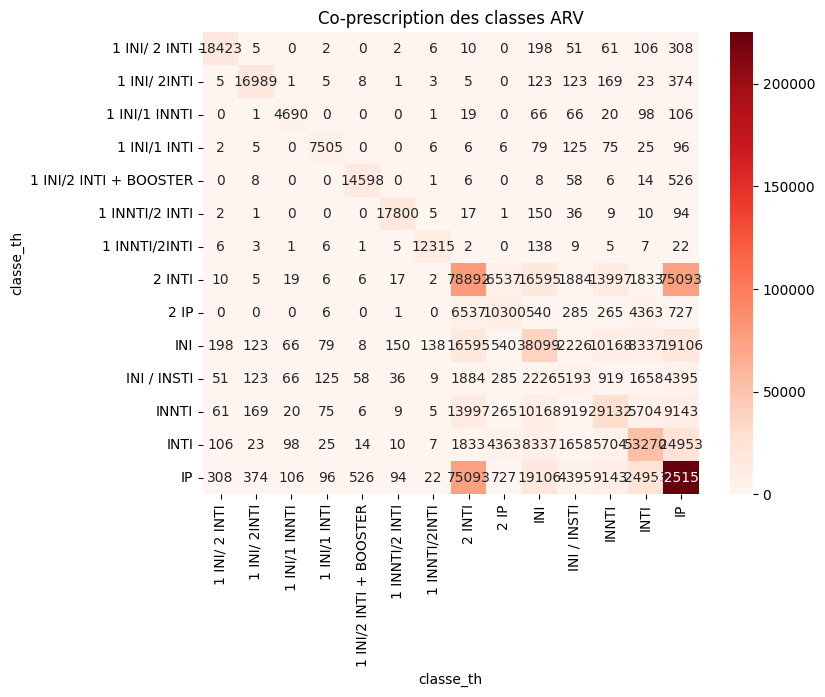

In [35]:
# Création matrice visite x classe
arv_matrix = (
    arv_df
    .dropna(subset=["classe_th"])
    .pivot_table(index="visite_id", columns="classe_th", aggfunc="size", fill_value=0)
)

co_prescription = arv_matrix.T.dot(arv_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(co_prescription, annot=True, fmt="d", cmap="Reds")
plt.title("Co-prescription des classes ARV")
plt.show()


## Effets indésirables (E_I)

### 7.2 Médicaments avec EI renseignés

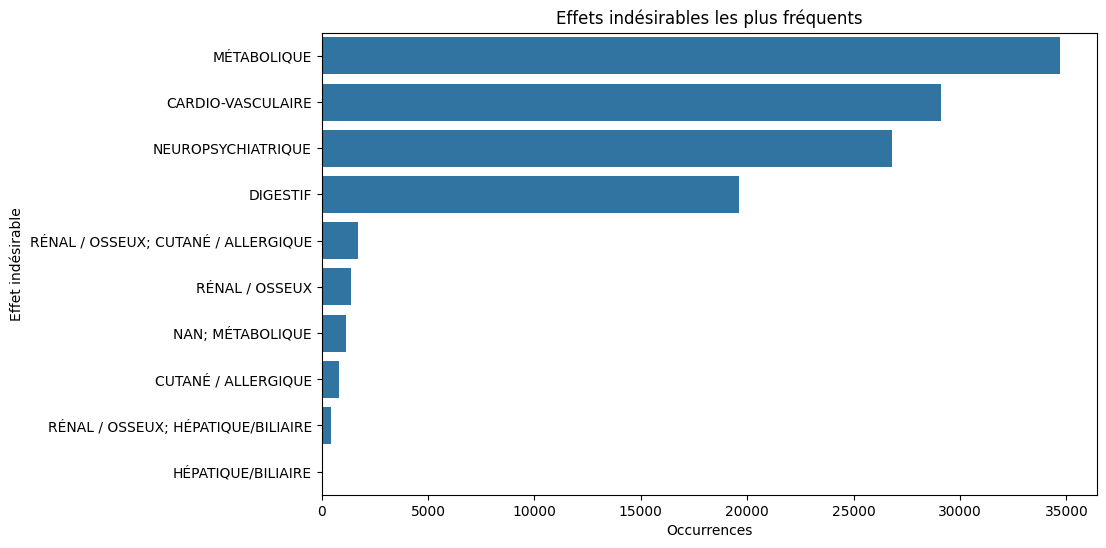

In [37]:
ei_df = df.dropna(subset=["E_I"])

top_ei = ei_df["E_I"].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_ei.values, y=top_ei.index)
plt.title("Effets indésirables les plus fréquents")
plt.xlabel("Occurrences")
plt.ylabel("Effet indésirable")
plt.show()


### 8.2 Exemple timeline patient

In [39]:
example_patient = df["ID"].value_counts().index[0]

timeline = (
    df[df["ID"] == example_patient]
    .sort_values("Date")[["Date", "Prelibt", "is_ARV"]]
)

timeline.head(10)


,Date,Prelibt,is_ARV
727941,2013-12-20,"SEBIPROX 1,5% SHAMP 100ML",0
727942,2013-12-20,DEXERYL CR DERM TUB 250G,0
727943,2013-12-20,"DERMOVAL 0,05% CR TUB 10G",0
727944,2013-12-20,AMYCOR 1% CR TUB 15G,0
727956,2013-12-23,INTELENCE 200MG CPR 60,1
727955,2013-12-23,LYRICA 100MG GELULE 84,0
727954,2013-12-23,"LOCOID 0,1% LOT 30ML",0
727953,2013-12-23,ZELITREX cp enrobé 500 mg,1
727951,2013-12-23,SERESTA 50MG CPR SECABLE 20,0
727952,2013-12-23,INEXIUM 40MG CPR 28,0


### 9.1 Visites à forte poly-médication

In [40]:
alert_visites = meds_per_visite[meds_per_visite >= 5]

len(alert_visites)


88227

### 9.2 Visites ARV + médicaments non ARV

In [4]:
arv_non_arv_visite = (
    df.groupby("visite_id")["is_ARV"]
    .agg(["sum", "count"])
)

arv_non_arv_visite["non_ARV"] = arv_non_arv_visite["count"] - arv_non_arv_visite["sum"]

arv_non_arv_visite.head()


,sum,count,non_ARV
visite_id,,,
1000000_2018-04-26,2,2,0
1000000_2018-05-18,2,2,0
100000_2016-11-23,3,3,0
10001_2023-06-07,1,5,4
10001_2023-06-23,2,2,0


In [5]:
arv_non_arv_visite

,sum,count,non_ARV
visite_id,,,
1000000_2018-04-26,2,2,0
1000000_2018-05-18,2,2,0
100000_2016-11-23,3,3,0
10001_2023-06-07,1,5,4
10001_2023-06-23,2,2,0
...,...,...,...
9_2021-01-07,1,3,2
9_2021-06-24,1,3,2
9_2022-03-10,1,3,2


## ...

### ....

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx


In [20]:
# On se concentre sur les médicaments non-ARV pour les EI
ei_df = df[(df["is_ARV"] == 0) & (df["E_I"].notna())]

# Normaliser les effets indésirables : parfois plusieurs effets dans la même cellule
ei_df["E_I_list"] = ei_df["E_I"].str.split(";|,")  # séparer par ; ou , si plusieurs EI
ei_df = ei_df.explode("E_I_list")
ei_df["E_I_list"] = ei_df["E_I_list"].str.strip().str.lower()  # nettoyage


C:\Users\toufi\AppData\Local\Temp\ipykernel_28008\219405454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ei_df["E_I_list"] = ei_df["E_I"].str.split(";|,")  # séparer par ; ou , si plusieurs EI


In [21]:
# On garde uniquement ARV et les EI associés à la même visite
arv_visite = df[df["is_ARV"] == 1][["visite_id","classe_th"]].dropna()
ei_visite = ei_df[["visite_id","E_I_list"]]

# Merge sur la visite
merged = arv_visite.merge(ei_visite, on="visite_id", how="inner")
merged.head()


,visite_id,classe_th,E_I_list
0,2_2021-09-13,1 INI/ 2INTI,neuropsychiatrique
1,2_2022-06-13,1 INI/ 2INTI,neuropsychiatrique
2,3_2023-11-06,1 INI/1 INNTI,métabolique
3,3_2023-11-06,1 INI/1 INNTI,métabolique
4,4_2009-05-12,IP,digestif


### Co-occurrence ARV et E_I 

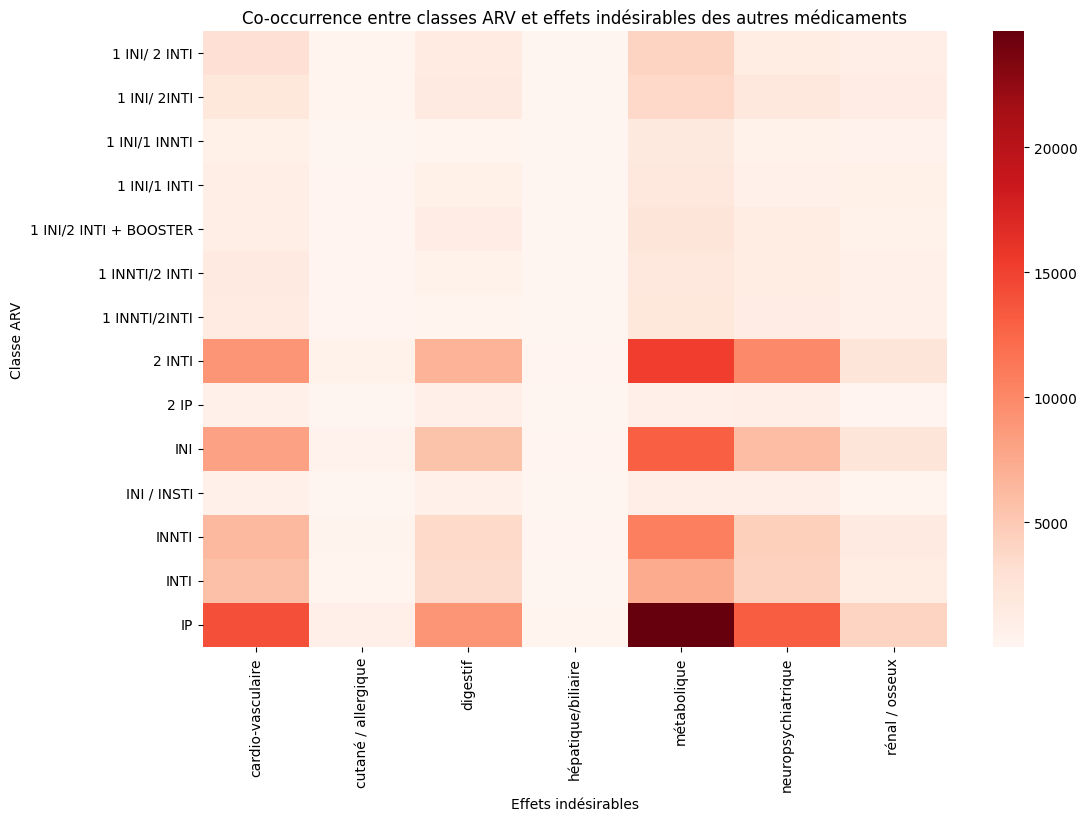

In [22]:
co_matrix = pd.crosstab(merged["classe_th"], merged["E_I_list"])

plt.figure(figsize=(12,8))
sns.heatmap(co_matrix, cmap="Reds", annot=False)
plt.title("Co-occurrence entre classes ARV et effets indésirables des autres médicaments")
plt.xlabel("Effets indésirables")
plt.ylabel("Classe ARV")
plt.show()


# Clustering 

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [6]:
df['is_non_ARV'] = 1 - df['is_ARV']


In [7]:
df['has_EI'] = df['E_I'].notna().astype(int)


In [9]:
patient_df = (
    df
    .groupby('ID')
    .agg(
        avg_ARV=('is_ARV', 'mean'),
        avg_non_ARV=('is_non_ARV', 'mean'),
        nb_visites=('Date', 'nunique'),
        freq_EI=('has_EI', 'mean')
    )
    .reset_index()
)


In [10]:
X = patient_df[['avg_ARV', 'avg_non_ARV', 'nb_visites']]


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
patient_df['cluster'] = kmeans.fit_predict(X_scaled)


In [13]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

patient_df['PC1'] = X_pca[:, 0]
patient_df['PC2'] = X_pca[:, 1]


In [15]:
print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)
print("Variance expliquée cumulée :", pca.explained_variance_ratio_.sum())


Variance expliquée par chaque composante : [0.68426619 0.31573381]
Variance expliquée cumulée : 1.0


In [17]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

patient_df['PC1'] = X_pca_3d[:, 0]
patient_df['PC2'] = X_pca_3d[:, 1]
patient_df['PC3'] = X_pca_3d[:, 2]


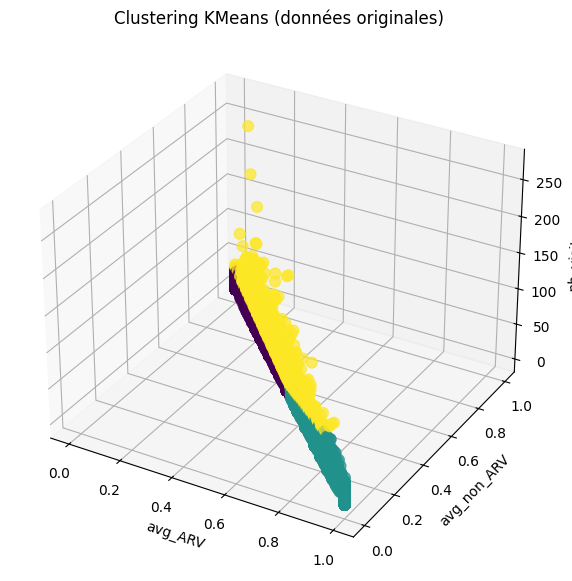

In [18]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    patient_df['avg_ARV'],
    patient_df['avg_non_ARV'],
    patient_df['nb_visites'],
    c=patient_df['cluster'],
    s=60,
    alpha=0.7
)

ax.set_xlabel('avg_ARV')
ax.set_ylabel('avg_non_ARV')
ax.set_zlabel('nb_visites')
ax.set_title('Clustering KMeans (données originales)')

plt.show()


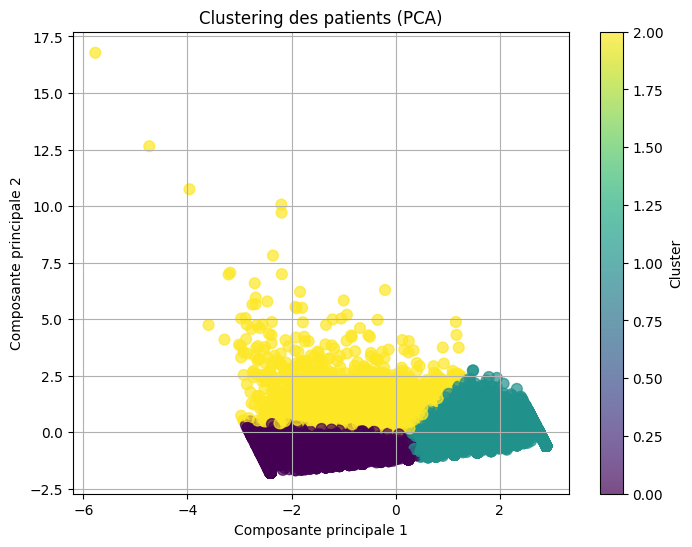

In [19]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    patient_df['PC1'],
    patient_df['PC2'],
    c=patient_df['cluster'],
    s=60,
    alpha=0.7
)

plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Clustering des patients (PCA)')

plt.colorbar(scatter, label='Cluster')
plt.grid(True)

plt.show()


In [25]:
# Ce graphe sert à identifier des profils de patients selon leur charge thérapeutique, leur suivi et la présence d’effets indésirables.

In [19]:
cluster_summary = (
    patient_df
    .groupby('cluster')
    .agg(
        avg_ARV=('avg_ARV', 'mean'),
        avg_non_ARV=('avg_non_ARV', 'mean'),
        avg_visites=('nb_visites', 'mean'),
        freq_EI=('freq_EI', 'mean'),
        nb_patients=('ID', 'count')
    )
)

cluster_summary


,avg_ARV,avg_non_ARV,avg_visites,freq_EI,nb_patients
cluster,,,,,
0,0.366271,0.633729,18.304356,0.038702,5464
1,0.788290,0.211710,14.545829,0.018844,4615
2,0.304326,0.695674,25.475899,0.286476,2780


In [27]:
cluster_labels = {
    0: "Patients complexes",
    1: "Patients stables",
    2: "Forte charge thérapeutique"
}

patient_df['cluster_label'] = patient_df['cluster'].map(cluster_labels)


In [29]:
patient_df

,ID,avg_ARV,avg_non_ARV,nb_visites,freq_EI,cluster,PC1,PC2,cluster_label
0,1,0.666667,0.333333,1,0.000000,1,1.309789,-1.001103,Patients stables
1,2,0.760870,0.239130,24,0.043478,1,1.291940,0.705112,Patients stables
2,3,0.200000,0.800000,1,0.400000,2,-2.237846,-1.407414,Forte charge thérapeutique
3,4,0.317554,0.682446,64,0.019724,0,-1.339880,2.752548,Patients complexes
4,5,0.695652,0.304348,10,0.000000,1,1.320181,-0.355314,Patients stables
...,...,...,...,...,...,...,...,...,...
12854,600000,0.833333,0.166667,6,0.000000,1,2.040625,-0.429768,Patients stables
12855,700000,0.357143,0.642857,5,0.000000,0,-0.238190,-1.169255,Patients complexes
12856,800000,0.392405,0.607595,21,0.240506,2,-1.079898,0.107681,Forte charge thérapeutique
12857,900000,0.769231,0.230769,10,0.076923,1,1.424447,-0.202875,Patients stables


<Figure size 700x500 with 0 Axes>

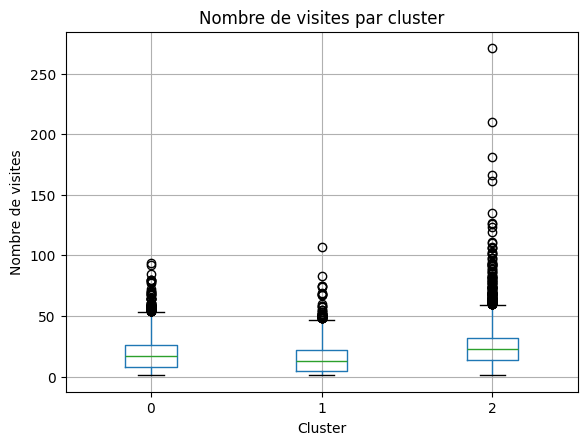

In [22]:
plt.figure(figsize=(7,5))
patient_df.boxplot(column='nb_visites', by='cluster')
plt.title('Nombre de visites par cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Nombre de visites')
plt.show()


<Figure size 700x500 with 0 Axes>

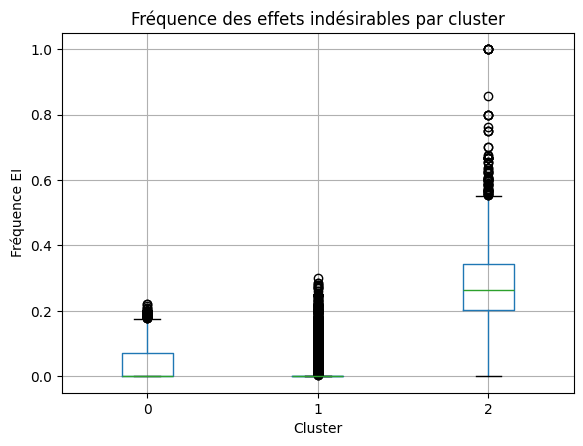

In [23]:
plt.figure(figsize=(7,5))
patient_df.boxplot(column='freq_EI', by='cluster')
plt.title('Fréquence des effets indésirables par cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Fréquence EI')
plt.show()


<Figure size 700x500 with 0 Axes>

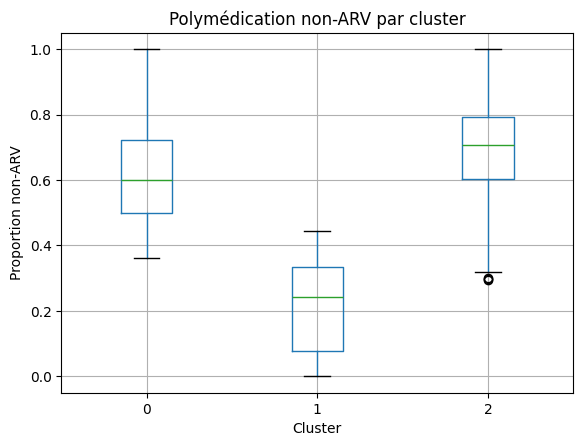

In [24]:
plt.figure(figsize=(7,5))
patient_df.boxplot(column='avg_non_ARV', by='cluster')
plt.title('Polymédication non-ARV par cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Proportion non-ARV')
plt.show()
